# 第十八、十九、二十次课-评分作业
**此次作业<span style="color:red;">成绩计入总评</span>，总分11分，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW18-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">6月10日23:59前</span>提交**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
torch.manual_seed(0)
np.random.seed(0)

### 读取数据并划分数据集（勿更改代码）

In [2]:

def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)

# 一、隐马尔可夫模型（2分）

### 1.1 准备数据（0.5分）

In [3]:
%pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
from hmmlearn import hmm
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
# 提取特征
def extract_features(data):
    # TODO: 0.5分
    all_chars = Counter("".join(data))
    char_to_index = {char: idx for idx, char in enumerate(all_chars.keys())}
    
    features = []
    lengths = []
    
    for line in data:
        features.append([char_to_index[char] for char in line])
        lengths.append(len(line))
        
    features = np.concatenate(features).reshape(-1, 1)
    return features, lengths

X_train_features, X_train_lengths = extract_features(X_train)
X_test_features, X_test_lengths = extract_features(X_test)


### 1.2 使用HMM模型进行训练、预测（1分）

In [6]:
# 训练HMM模型
hmm_model = hmm.MultinomialHMM(n_components=n_tags, n_iter=100)
hmm_model.fit(X_train_features, X_train_lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=14, n_iter=100,
               n_trials=array([ 0,  1,  2, ..., 39, 23, 35]),
               random_state=RandomState(MT19937) at 0x7FC398096940)

In [7]:
# HMM预测
def hmm_predict(model, X, lengths):
    # TODO: 1分
    preds = []
    start = 0
    
    for length in lengths:
        end = start + length
        seq = X[start : end]
        logprob, state_sequence = model.decode(seq, algorithm='viterbi')
        preds.append(Counter(state_sequence).most_common(1)[0][0])
        start = end
        
    return np.array(preds)
    
y_train_pred = hmm_predict(hmm_model, X_train_features, X_train_lengths)
y_test_pred = hmm_predict(hmm_model, X_test_features, X_test_lengths)

### 1.3 模型评估（0.5分）

In [8]:
from sklearn.metrics import accuracy_score
# 评估函数
def evaluate(y_true, y_pred):
    # TODO: 0.5分
    return accuracy_score(y_true, y_pred)

# HMM结果
print("HMM结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

HMM结果
train set accuracy: 0.0477
test set accuracy: 0.0479


## 二、RNN模型的应用（3分）

### 2.1 数据准备和预处理（0.5分）

### 字符的编码

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [9]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = ""
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters)

In [10]:
#function to create name representation

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep


In [11]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [12]:
#create a dataloader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

def dataloader(batch_size, X_, y_):
    to_ret = []
    for i in range(batch_size):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, lang, name_rep(name), nat_rep(lang)))

    return to_ret


### 2.2 RNN网络的搭建（1分）

In [13]:
class RNN_net(nn.Module):
    # TODO: 1分
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    

### 2.3 模型的训练（1分）

In [14]:
# function to train the data

def train_step(net, opt, criterion, batch_size):
    
    # TODO: 0.5分   
    opt.zero_grad()
    total_loss = 0
    data_ = dataloader(batch_size, X_train, y_train)
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/batch_size

In [15]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):


    # TODO: 0.5分
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    criterion = nn.NLLLoss()
    
    loss_arr = np.zeros(steps)

    #iterate through all the batches
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1)%freq==0: 
            print("Iteration number:", i + 1,'Loss:', round(loss_arr[i],4))

    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")

RNN_net(
  (i2h): Linear(in_features=201, out_features=128, bias=True)
  (i2o): Linear(in_features=201, out_features=14, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Iteration number: 5 Loss: 2.6217
Iteration number: 10 Loss: 2.5337
Iteration number: 15 Loss: 2.4263
Iteration number: 20 Loss: 2.2613
Iteration number: 25 Loss: 2.1565
Iteration number: 30 Loss: 2.0855
Iteration number: 35 Loss: 1.9785
Iteration number: 40 Loss: 2.0459
Iteration number: 45 Loss: 1.9822
Iteration number: 50 Loss: 1.9897
Iteration number: 55 Loss: 1.8559
Iteration number: 60 Loss: 1.878
Iteration number: 65 Loss: 1.8534
Iteration number: 70 Loss: 1.8572
Iteration number: 75 Loss: 1.8296
Iteration number: 80 Loss: 1.7334
Iteration number: 85 Loss: 1.7764
Iteration number: 90 Loss: 1.6925
Iteration number: 95 Loss: 1.6769
Iteration number: 100 Loss: 1.5839
Iteration number: 105 Loss: 1.6625
Iteration number: 110 Loss: 1.4557
Iteration number: 115 Loss: 1.5937
Iteration number: 120 Loss: 1.4252
Iteration number: 125 Loss: 1.3928
Iteration number: 130 Loss: 1.3509
Iteration number: 135 Loss: 1.4902
Iteration number: 140 Loss: 1.4469
Iteration number: 145 Loss: 1.3309
Iterat

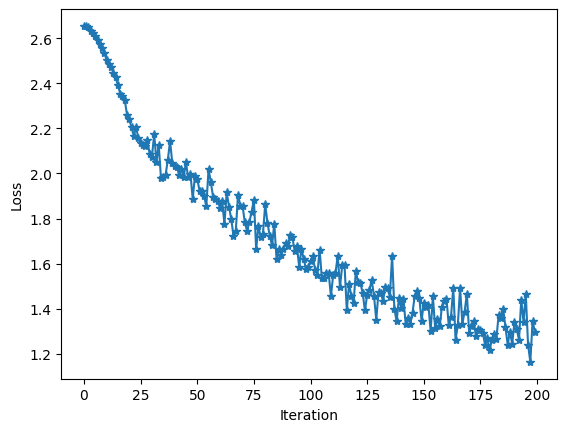

In [16]:
# RNN训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
print(rnn_net)
train(rnn_net, lr = 0.0001, steps = 200, batch_size = 256)

### 2.4 模型的评估（0.5分）

In [17]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [18]:
#create a function to evaluate model

def eval_test(net):
     correct = 0
     for i in range(len(X_test)):
        name,lang = X_test[i],y_test[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_test)

     return accuracy

In [19]:
#create a function to evaluate model

def eval_train(net):
     # TODO: 0.5分
     correct = 0
     for i in range(len(X_train)):
        name,lang = X_train[i],y_train[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_train)

     return accuracy

In [20]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果


train set accuracy:0.5928
test set accuracy:0.5888


RNN_lstm_net(
  (lstm): LSTM(73, 128)
  (hidden2tag): Linear(in_features=128, out_features=14, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Iteration number: 5 Loss: 2.6517
Iteration number: 10 Loss: 2.612
Iteration number: 15 Loss: 2.532
Iteration number: 20 Loss: 2.4451
Iteration number: 25 Loss: 2.2121
Iteration number: 30 Loss: 2.336
Iteration number: 35 Loss: 2.1506
Iteration number: 40 Loss: 2.1552
Iteration number: 45 Loss: 2.1437
Iteration number: 50 Loss: 2.162
Iteration number: 55 Loss: 2.0892
Iteration number: 60 Loss: 2.1254
Iteration number: 65 Loss: 2.0934
Iteration number: 70 Loss: 2.0058
Iteration number: 75 Loss: 2.0517
Iteration number: 80 Loss: 2.0437
Iteration number: 85 Loss: 1.9244
Iteration number: 90 Loss: 1.9073
Iteration number: 95 Loss: 1.8529
Iteration number: 100 Loss: 1.8234
Iteration number: 105 Loss: 1.8461
Iteration number: 110 Loss: 1.8611
Iteration number: 115 Loss: 1.697
Iteration number: 120 Loss: 1.6923
Iteration number: 125 Loss: 1.7366
Iteration number: 130 Loss: 1.6733
Iteration number: 135 Loss: 1.5467
Iteration number: 140 Loss: 1.5485
Iteration number: 145 Loss: 1.4117
Iteration 

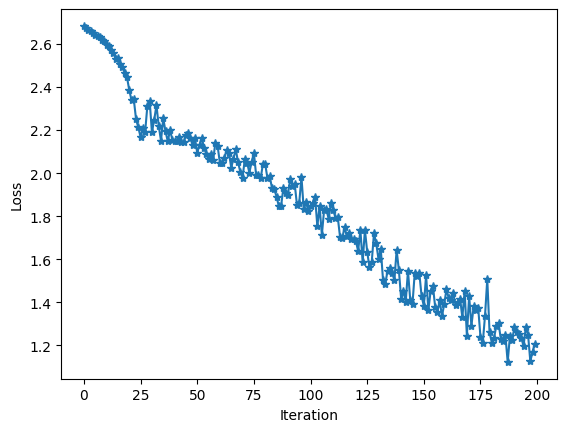

In [21]:
class RNN_lstm_net(nn.Module):
    # TODO: 1分
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_lstm_net, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2tag = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):
        lstm_out, hidden = self.lstm(input_.view(len(input_), 1, -1), hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(input_), -1))
        tag_scores = self.softmax(tag_space)
        return tag_scores, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))
        
def train(net, lr=0.01, steps=100, batch_size=10, momentum=0.9, freq=5):
    opt = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    loss_arr = np.zeros(steps)
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1) % freq == 0: 
            print("Iteration number:", i + 1, 'Loss:', round(loss_arr[i], 4))
    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")
    
n_hidden = 128
lstm_net = RNN_lstm_net(n_letters, n_hidden, len(tags))
print(lstm_net)
train(lstm_net, lr=0.0008, steps=200, batch_size=256)

In [22]:
print("LSTM结果")
print("train set accuracy:"+str(round(eval_train(lstm_net),4)))
print("test set accuracy:"+str(round(eval_test(lstm_net),4)))

LSTM结果


train set accuracy:0.6304
test set accuracy:0.6236


## 三、预训练模型的使用（3分）

### 3.1 数据准备和预处理，模型的导入（0.5分）

In [23]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# 初始化BERT模型和tokenizer
cache_dir = '/DATA/sqf/MovieLensFinal/hub'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
bert_model = BertModel.from_pretrained('bert-base-uncased', cache_dir=cache_dir)

/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3.2 使用BERT进行特征提取（1分）

In [24]:
from tqdm import tqdm
# 提取BERT特征
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
bert_model.to(device)

def extract_bert_features(data):
    features = []
    # TODO: 1分
    
    features = []
    for text in tqdm(data, desc="Extracting BERT features"):
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
        inputs = {key: value.to(device) for key, value in inputs.items()} 
        with torch.no_grad():
            outputs = bert_model(**inputs)
        # 取[CLS] token的特征
        cls_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(cls_features)
    return np.vstack(features)

# 提取训练集和测试集的特征
X_train_features = extract_bert_features(X_train)
X_test_features = extract_bert_features(X_test)

cuda


Extracting BERT features: 100%|██████████| 2128/2128 [00:21<00:00, 97.86it/s]


In [25]:
# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### 3.3 使用一个分类器对提取好的特征进行分类（1分）

In [26]:
# TODO: 1分
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_features, y_train_encoded)

LogisticRegression(max_iter=1000)

In [27]:
# 预测
y_train_pred = clf.predict(X_train_features)
y_test_pred = clf.predict(X_test_features)

### 3.4 评估结果（0.5分）

In [28]:
# 评估函数
def evaluate(y_true, y_pred):
    # TODO: 0.5分
    return accuracy_score(y_true, y_pred)

# BERT结果
print("BERT结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

BERT结果
train set accuracy: 0.9061
test set accuracy: 0.7909


## 四、三种模型的总结与分析（1分）

请简述这次作业使用的数据集在三种模型下的表现产生显著差异的原因，并且给出能够提高HMM表现的数据加强方式。

|        | HMM| RNN|LSTM|BERT|
|------------|-----------|-----------|-----------|-----------|
| Train Accuracy  | 0.0477|0.5928|0.6304|0.9061|
| Test Accuracy   | 0.0479|0.5888|0.6236|0.7909|

#### HMM
HMM 是基于概率图模型的序列数据模型，局限性在于它假设序列中的观测值和状态之间的关系是独立同分布的，由于没有提供更多的信息和特征增强，所以导致在较复杂的语言任务上并不能很好理解语义，效果不佳。

#### RNN/LSTM
这两种模型都尝试捕捉序列中的时序信息。而LSTM由于增加了一个记忆细胞，可以更好地处理梯度消失和梯度爆炸问题，解决不同时间跨度下的依赖问题，所以结果优于RNN。不过在数据集较小的情况下都并没有特别好的效果。

#### BERT
BERT 是一种基于 Transformer 的预训练语言模型。由于它已经在大规模数据集上进行了预训练，因此已经能很好地捕捉任意数据上上下文的特征和信息，即使我们并没有进行微调，也能达到不错的效果。如果我们进一步微调，可能会在测试集上有更好的表现。


#### 提高HMM表现的数据增强方式
1. 增加训练数据量，可以帮助模型更好地估计状态转移的概率分布，提高模型性能。
2. 可以引入更多特征，比如对于词的词性标签，上下文作为位置编码的一部分。
3. 使用平滑技术（如拉普拉斯平滑）来处理低频或未见过的状态和观测，防止模型在遇到未见过的数据时表现不佳。

## 附加题：期末笔试题目的参考

### 附加题 马尔可夫模型的原理理解（1分）

(1) 阅读以下题目，补全solve函数，并且将结果提交到codeforces平台上，将代码运行结果截图（包含用户名、AC的结果、运行时间等信息）（0.5分）

提交的网址：https://codeforces.com/problemset/problem/1025/G

运行结果截图

![](./3.png)

![](./1.png)

In [29]:
def solve(n,lis):
    print((2**(n-1)-1-sum([2**lis.count(x)-1 for x in set(lis)-set(['-1'])]))%(10**9+7))

n=int(input())
lis=input().split()
solve(n,lis)

ValueError: invalid literal for int() with base 10: ''

![截屏2024-06-08 16.25.56.png](<attachment:截屏2024-06-08 16.25.56.png>)
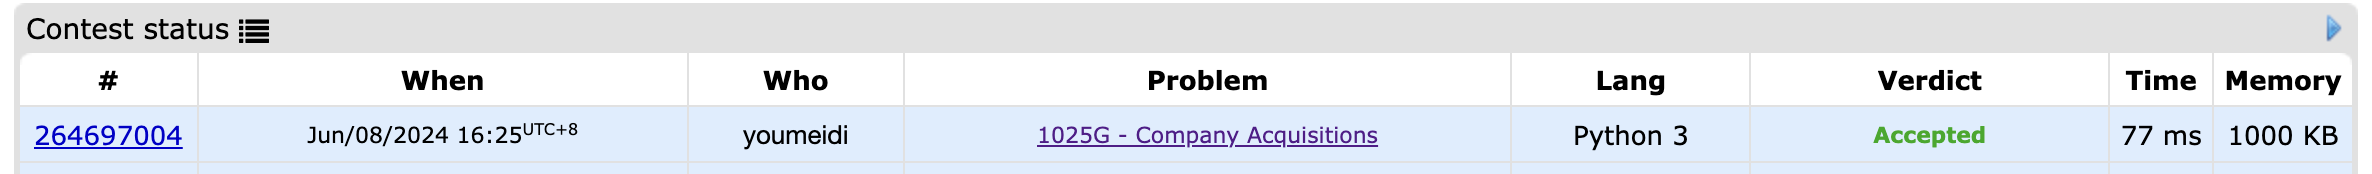

(2) 对以上代码的正确性给出证明（0.5分）

方法一：
![](./4.png)

方法2:
![](./5.png)